In [1]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )
sys.path.append( '..' )
from helpers import *
from FIA import *
from ML4com import *
from DL4com import *

In [2]:
# Load matrices
mat_to_tsv_batch("../../data/comm8_0")

strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t") # type: ignore

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ),
                           total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

In [3]:
# Define data
X = met_raw_comb.transpose()
ys = comm8

## Model

### Hyperparameter optimization

In [4]:
configuration_space = ConfigurationSpace()
max_layers = 5
dropout_in = Float("dropout_in", (0.0, 0.8), default=0.5)

n_layers = Integer("n_layers", (1, max_layers), default=1)
n_neurons = []
activations = []
dropouts =[]
for i in range(max_layers):
    n_neurons.append(Integer(f"n_neurons_{i}", (10, 1000), log=True, default=10))
    activations.append( Categorical(f"activation_{i}", ["tanh", "relu", "leakyrelu", "sigmoid"], default="relu") )
    dropouts.append( Categorical(f"dropout_{i}", [True, False], default=True) )

solver = Categorical("solver", ["nadam"], default="nadam")
learning_rate = Float("learning_rate", (1e-3, 1e-1), log=True, default=1e-2)

hyperparameters = n_neurons + activations + dropouts + [dropout_in, n_layers, solver, learning_rate]
configuration_space.add_hyperparameters(hyperparameters)

[n_neurons_0, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_1, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_2, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_3, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_4, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 activation_0, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_1, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_2, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_3, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_4, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 dropout_0, Type: Categorical, Choices: {True, False}, Default: True,
 dropout_1, Type: Categorical, Choices: {True, False}, Defau

In [5]:
outdir = Path(os.path.normpath("/mnt/d/runs/ML/NN/smac"))
cpus = 1
classifier = Classifier(X, ys, test_size=0.2, configuration_space=configuration_space, model_builder=build_classification_model, model_args={"classes": 1})

# Define our environment variables
scenario = Scenario( classifier.configspace, n_trials=10000,
                    min_budget=5, max_budget=100,
                    n_workers=cpus, output_directory=outdir,
                    walltime_limit=12*60*60, cputime_limit=np.inf, trial_memory_limit=int(6e10)    # Max RAM in Bytes (not MB) 3600 = 1h
                    )

initial_design = MultiFidelityFacade.get_initial_design(scenario, n_configs=100)

intensifier = Hyperband(scenario, incumbent_selection="highest_budget")

# Create our SMAC object and pass the scenario and the train method
smac = MultiFidelityFacade( scenario, classifier.train, 
                           initial_design=initial_design, intensifier=intensifier,
                           overwrite=False, logging_level=20
                           )
                           
tf.config.threading.set_inter_op_parallelism_threads(cpus)

[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.
[INFO][smbo.py:497] Continuing from previous run.


In [6]:
incumbent = smac.optimize()

[INFO][smbo.py:270] Optimization process was already finished. Returning incumbent...


### Save history

In [7]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent
incumbent_cost = smac.validate(best_hp)
print(f"Incumbent cost of continued run: {incumbent_cost}")
send_mail(subject="Classifier Tuning", message=f"\nHyperparameter search finished with cost {incumbent_cost} at:\n{dict(best_hp)}",
          pw_file="/mnt/c/Users/JosuaCarl/Desktop/keys/pw.txt", private_key="/mnt/c/Users/JosuaCarl/Desktop/keys/privatekey.pem")

RuntimeError: Please call __post_init__ before calling this method.

In [9]:
results = pd.DataFrame(columns=["config_id", "config", "instance", "budget", "seed", "loss", "time", "status", "additional_info"])
for trial_info, trial_value in smac.runhistory.items():
    results.loc[len(results.index)] = [trial_info.config_id, dict(smac.runhistory.get_config(1)), trial_info.instance,
                                       trial_info.budget, trial_info.seed,
                                       trial_value.cost, trial_value.time, trial_value.status, trial_value.additional_info]
results

,config_id,config,instance,budget,seed,loss,time,status,additional_info
0,1,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.692519,5.648537,1,{}
1,2,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.780937,7.979464,1,{}
2,3,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.691562,7.908545,1,{}
3,4,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.673983,8.717660,1,{}
4,5,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.893800,8.812661,1,{}
...,...,...,...,...,...,...,...,...,...
239,185,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,100.000000,209652396,0.588785,8.966356,1,{}
240,186,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,100.000000,209652396,0.701655,21.000801,1,{}
241,187,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,100.000000,209652396,0.669784,9.115000,1,{}
242,188,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.853201,4.311765,1,{}


### Classification

In [10]:
metrics_df = cross_validate_model(X, ys, strains["0"], config=best_hp, classes=1,
								  fold=StratifiedKFold(n_splits=5), patience=1000, epochs=100000,
								  verbosity=0)

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step
[WARNING][polymorphic_function.py:156] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2f58c3fec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 62ms/step


 12%|█▎        | 1/8 [02:32<17:49, 152.73s/it]

[WARNING][polymorphic_function.py:156] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2eebc17880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 61ms/step


 25%|██▌       | 2/8 [05:10<15:34, 155.83s/it]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 3/8 [07:46<12:58, 155.78s/it]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 4/8 [10:27<10:31, 157.81s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████▎   | 5/8 [13:00<07:48, 156.08s/it]

1/1 [==============================] - 0s 60ms/step


In [ ]:
metrics_df

NameError: name 'metrics_df' is not defined

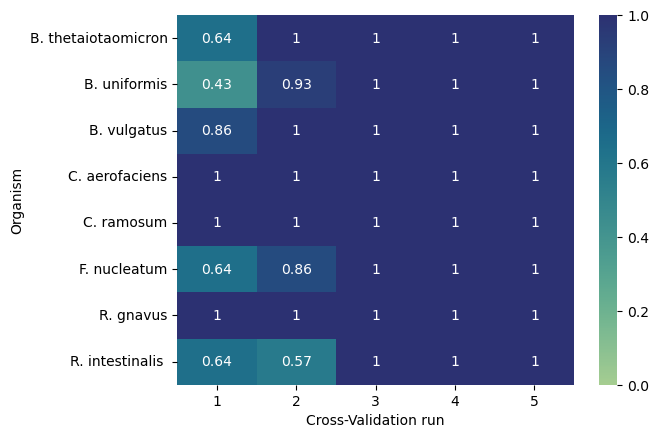

In [ ]:
# Accuracy CV matrix
ax = sns.heatmap(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy"),
                 vmin=0, vmax=1.0, annot=True, cmap=sns.color_palette("crest", as_cmap=True))
plt.savefig('../../runs/ML/annot/multi_layer_perceptron/heatmap_accuracies_1.png')  

In [ ]:
plot_cv_confmat(ys=ys, target_labels=strains.values,
                accuracies=np.mean(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").values, axis=1),
                confusion_matrices=np.sum(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Conf_Mat").values, axis=1),
				outdir="../../runs/ML/annot/multi_layer_perceptron", name="class_annot_test_smac")